In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("../data/raw/Dataset.csv")

In [4]:
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Basic Dataset Understanding

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Result
Mix of categorical and numerical features
Target variable: Churn
Some missing values in TotalCharges

Data Cleaning

In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].isnull().sum()


np.int64(11)

In [7]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [8]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

Why map churn now?
So we can do numeric analysis & statistics.

Target Distribution (Churn Rate)

In [9]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Explanation:
Around 25–30% of customers churn, indicating a significant retention problem.

Tenure vs Churn (Lifecycle Effect)

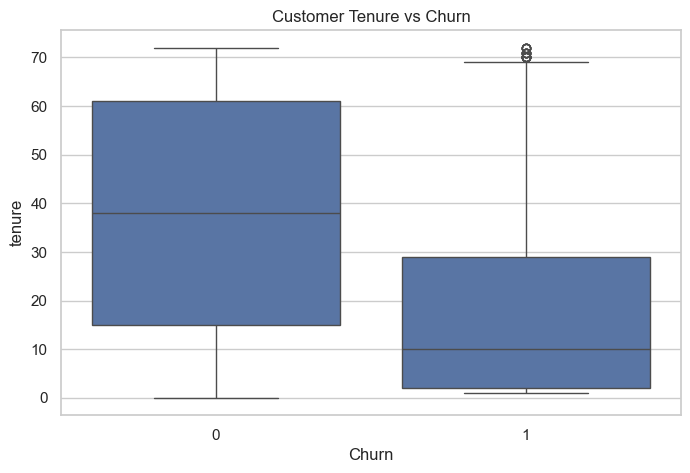

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Customer Tenure vs Churn")
plt.show()


Insight:
Churned customers have much lower tenure
New customers are more likely to churn

Contract Type vs Churn

In [11]:
contract_churn = pd.crosstab(df["Contract"], df["Churn"], normalize="index")

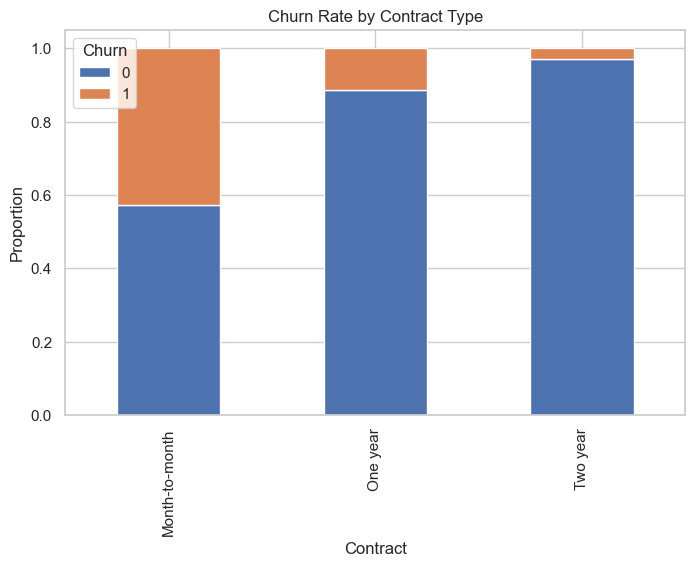

In [12]:
contract_churn.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Churn Rate by Contract Type")
plt.ylabel("Proportion")
plt.show()

Insight:
Month-to-month contracts have highest churn
Long-term contracts reduce churn risk

Pricing Impact (Monthly Charges)

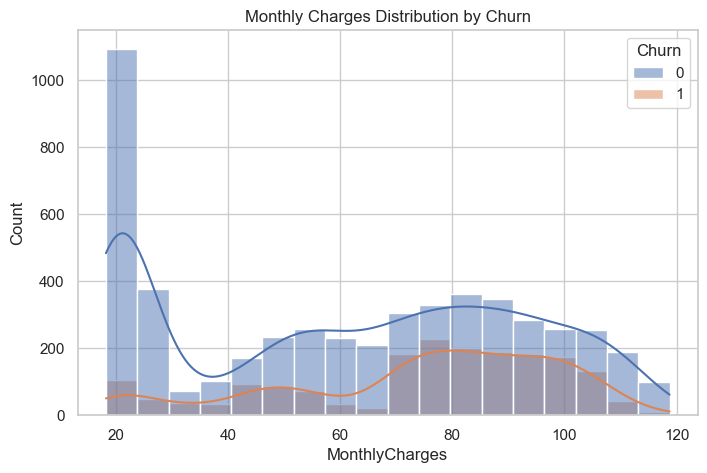

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="MonthlyCharges", hue="Churn", kde=True)
plt.title("Monthly Charges Distribution by Churn")
plt.show()


Insight:
Customers with higher monthly charges churn more
Pricing pressure is a major churn driver

Service Quality (Tech Support)

In [14]:
tech_churn = pd.crosstab(df["TechSupport"], df["Churn"], normalize="index")

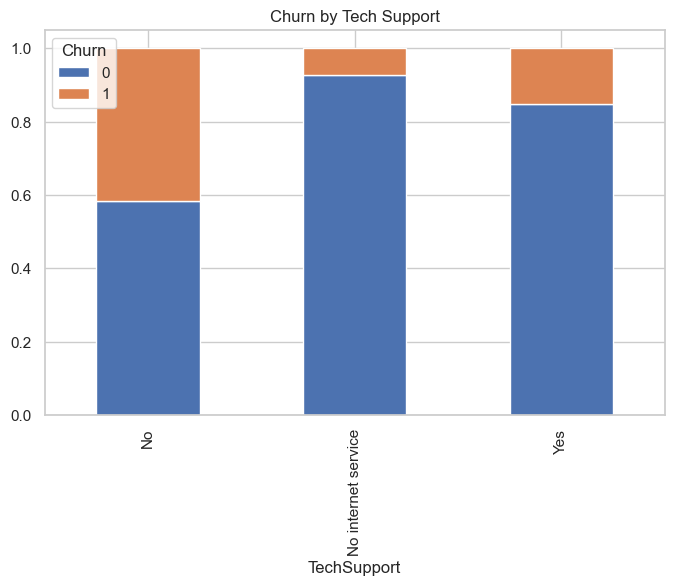

In [15]:
tech_churn.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Churn by Tech Support")
plt.show()

Insight:
Lack of tech support → higher churn
Support services improve retention

Payment Behavior

In [16]:
pay_churn = pd.crosstab(df["PaymentMethod"], df["Churn"], normalize="index")

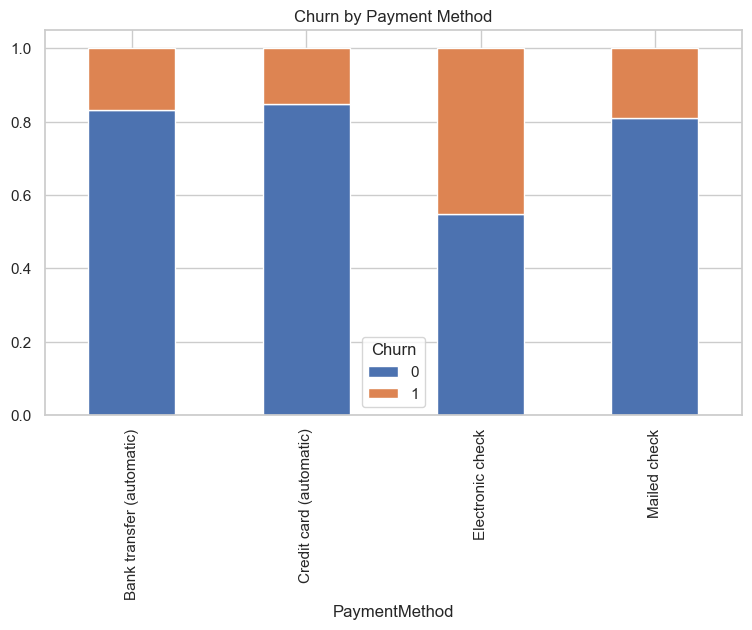

In [17]:
pay_churn.plot(kind="bar", stacked=True, figsize=(9,5))
plt.title("Churn by Payment Method")
plt.show()

Insight:
Electronic check users churn more
Indicates lower trust / weaker engagement

Statistical Validation

Monthly Charges Difference

In [18]:
from scipy.stats import mannwhitneyu


In [19]:
charges_churn = df[df["Churn"] == 1]["MonthlyCharges"]
charges_no_churn = df[df["Churn"] == 0]["MonthlyCharges"]

In [20]:
u_stat, p_value = mannwhitneyu(charges_churn, charges_no_churn)
u_stat, p_value


(np.float64(6003125.5), np.float64(3.311627651988584e-54))

Explaination:
Pricing difference between churned and retained customers is statistically significant.

Contract vs Churn (Chi-Square)

In [21]:
from scipy.stats import chi2_contingency

In [22]:
contract_table = pd.crosstab(df["Contract"], df["Churn"])
chi2, p, _, _ = chi2_contingency(contract_table)

In [23]:
chi2, p

(np.float64(1184.5965720837926), np.float64(5.863038300673391e-258))

Confirms contract type strongly affects churn.

Revenue at Risk

In [24]:
df["RevenueAtRisk"] = df["MonthlyCharges"] * df["Churn"]


Text(0, 0.5, 'Revenue at Risk')

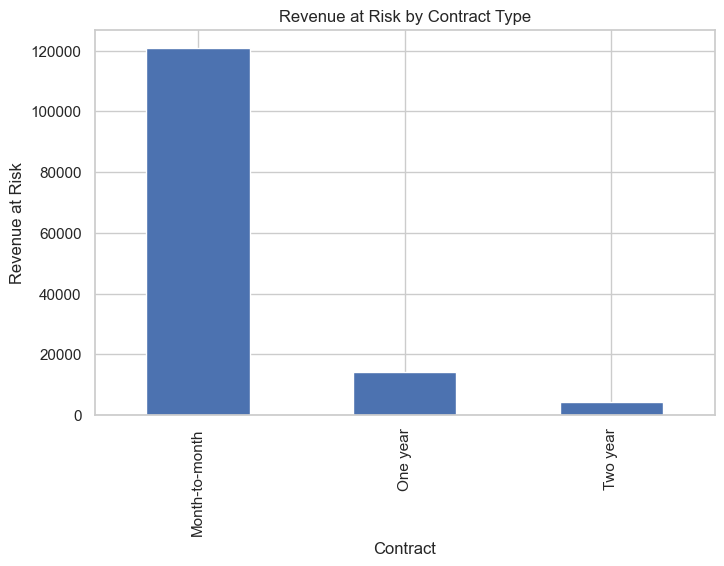

In [26]:
df.groupby("Contract")["RevenueAtRisk"].sum().plot(
    kind="bar",
    figsize=(8,5),
    title="Revenue at Risk by Contract Type"
)
plt.ylabel("Revenue at Risk")

Business insight:
Month-to-month customers contribute most to potential revenue loss.

In [28]:
import sys 
sys.path.append("..")

In [29]:
from src.utils.preprocessing import apply_feature_engineering